### PPO training and evaluation pipeline

In [4]:
import os
import torch
import sys
sys.path.append('..')
from cathedral_rl import cathedral_v0  
from models.ppo_cnn import PPOCNN
from ppo_utils import create_game_gif, RolloutBuffer, evaluate_ppo_against_random

In [5]:
################################## set device ##################################

print("============================================================================================")


# set device to cpu or cuda
device = torch.device('cpu')

if(torch.cuda.is_available()): 
    device = torch.device('cuda:0') 
    torch.cuda.empty_cache()
    print("Device set to : " + str(torch.cuda.get_device_name(device)))
else:
    print("Device set to : cpu")
    
print("============================================================================================")



Device set to : NVIDIA GeForce RTX 3050 Laptop GPU


### PPO CNN

In [6]:
K_epochs = 20               # update policy for K epochs
eps_clip = 0.1             # clip parameter for PPO
gamma = 0.97                # discount factor
gae_lambda = 0.95

lr_actor = 0.0005       # learning rate for actor network
lr_critic = 0.0002

board_size = 8
num_episodes = 10000
save_freq = 1000

### Pure self play of PPO vs itself

In [7]:
def train_ppo_self_play(name):
    env = cathedral_v0.env(board_size=board_size, render_mode="text", per_move_rewards=True, final_reward_score_difference=False)
    env.reset()
    
    gif_dir = os.path.join("game_recordings", name)
    os.makedirs(gif_dir, exist_ok=True)
    
    # Get action space and observation shape (should be the same for both players)
    player_0 = "player_0"
    player_1 = "player_1"
    list_agents = env.agents
    n_actions = env.action_space(player_0).n
    obs_shape = env.observe(player_0)["observation"].shape  # (10, 10, 5)
    
    episodes_per_update = 5
    episode_counter = 0
    
    print(f'n_actions: {n_actions}')
    print(f'observation shape: {obs_shape}')
    
    # Initialize primary PPO agent (the one that will be learning)
    primary_agent = PPOCNN(
        obs_shape=obs_shape,
        action_dim=n_actions,
        lr_actor=lr_actor,
        lr_critic=lr_critic,
        gamma=gamma,
        K_epochs=K_epochs,
        eps_clip=eps_clip
    )
    
    # Initialize target PPO agent (the opponent that will be periodically updated)
    target_agent = PPOCNN(
        obs_shape=obs_shape,
        action_dim=n_actions,
        lr_actor=lr_actor,
        lr_critic=lr_critic,
        gamma=gamma,
        K_epochs=K_epochs,
        eps_clip=eps_clip
    )
    
    # Clone the primary agent weights to target agent initially
    target_agent.policy.load_state_dict(primary_agent.policy.state_dict())
    
    # Training statistics
    list_reward_p0 = []
    list_reward_p1 = []
    policy_checkpoints = []
    list_win_count_p0 = []
    list_win_count_p1 = []
    list_draw_count = []
    surr1_array = []
    surr2_array = []
    values_array = []
    mse_loss_array = []
    total_loss_array = []
    ratio_array = []
    ratio_std_array = []
    ppo_win_rates = []
    random_win_rates = []
    draw_rates = []
    eval_episodes = []
    
    # Initialize tracking lists
    if not list_win_count_p0:
        list_win_count_p0 = [0]
    if not list_win_count_p1:
        list_win_count_p1 = [0]
    if not list_draw_count:
        list_draw_count = [0]
    
    # Training loop
    for episode in range(num_episodes):
        env.reset()
        list_agents = env.agents.copy()
        episode_buffer = RolloutBuffer()  # Create a fresh buffer for this episode
        total_reward_p0 = 0
        total_reward_p1 = 0
        
        # Game loop
        while env.agents:
            current_agent = env.agent_selection
            observation = env.observe(current_agent)
            state = observation["observation"]
            action_mask = observation["action_mask"]
            
            # Player 0 (primary agent) is learning
            if current_agent == player_0:
                # Select action and store initial experience
                action = primary_agent.select_action_episodic(state, action_mask, episode_buffer)
            else:
                # Target agent selects action (no exploration)
                with torch.no_grad():
                    action = target_agent.select_action_evaluation(state, action_mask)
            
            # Take action in environment
            prev_observe = observation  # Store pre-action observation
            env.step(action)
            
            # Get rewards
            reward_p0 = env.rewards["player_0"]
            reward_p1 = env.rewards["player_1"]
            
            # Check if game is over
            game_over = (len(env.legal_moves[player_0]) == 0 and 
                         len(env.legal_moves[player_1]) == 0)
            
            # For primary agent (player 0) only, store experience
            if current_agent == player_0:
                # Store reward and terminal information
                episode_buffer.rewards.append(reward_p0)
                is_terminal = (current_agent not in env.agents) or game_over
                episode_buffer.is_terminals.append(1 if is_terminal else 0)
                
                # Track total rewards
                total_reward_p0 += reward_p0
            else:
                total_reward_p1 += reward_p1
        
        # After episode ends, add this episode's experiences to the main buffer
        primary_agent.add_episode_buffer(episode_buffer)
        episode_counter += 1
        
        # Update statistics
        list_reward_p0.append(total_reward_p0)
        list_reward_p1.append(total_reward_p1)
        
        # Update the appropriate counter based on the game outcome
        winner = env.winner
        
        if list_agents[winner] == 'player_0':  # primary agent wins
            list_win_count_p0.append(list_win_count_p0[-1] + 1)
            list_win_count_p1.append(list_win_count_p1[-1])
            list_draw_count.append(list_draw_count[-1])
            
        elif list_agents[winner] == 'player_1':  # target agent wins
            list_win_count_p0.append(list_win_count_p0[-1])
            list_win_count_p1.append(list_win_count_p1[-1] + 1)
            list_draw_count.append(list_draw_count[-1])
            
        elif winner == -1:  # draw
            list_win_count_p0.append(list_win_count_p0[-1])
            list_win_count_p1.append(list_win_count_p1[-1])
            list_draw_count.append(list_draw_count[-1])
        
        # Only update model after collecting experiences from multiple episodes
        if episode_counter >= episodes_per_update:
            surr_1, surr_2, value, mse_loss, total_loss, ratio, ratio_std = primary_agent.update()
            # Reset episode counter after update
            episode_counter = 0
            
            print(f'Ratio {ratio}, std {ratio_std}')
            print(f'Surr1 = {surr_1}, surr2 {surr_2}, avg value {value}, mse_loss {mse_loss}, total_loss {total_loss}')
            # Record metrics only when updates happen
            surr1_array.append(surr_1)
            surr2_array.append(surr_2)
            values_array.append(value)
            mse_loss_array.append(mse_loss)
            total_loss_array.append(total_loss)
            ratio_array.append(ratio)
            ratio_std_array.append(ratio_std)
        
        # Update target network with soft updates more frequently
        if (episode + 1) % 10 == 0:
            # Soft update (interpolate between models)
            for target_param, param in zip(target_agent.policy.parameters(), 
                                          primary_agent.policy.parameters()):
                target_param.data.copy_(
                    0.7 * target_param.data + 0.3 * param.data
                )
                
            target_agent.policy_old.load_state_dict(target_agent.policy.state_dict())
        if (episode + 1) % 5 == 0:
            win_rate_p0 = list_win_count_p0[-1] / (episode + 1)
            win_rate_p1 = list_win_count_p1[-1] / (episode + 1)
            draw_rate = list_draw_count[-1] / (episode + 1)
            
            print(f"Episode {episode+1}/{num_episodes}")
            print(f"  Primary Agent (P0) - Avg Reward: {sum(list_reward_p0[-100:]) / min(100, len(list_reward_p0)):.2f} - Win Rate: {win_rate_p0:.2f}")
            print(f"  Target Agent (P1) - Avg Reward: {sum(list_reward_p1[-100:]) / min(100, len(list_reward_p1)):.2f} - Win Rate: {win_rate_p1:.2f}")
            print(f"  Draw Rate: {draw_rate:.2f}")

        if (episode + 1) % 100 == 0:
            # Complete copy of primary agent
            target_agent.policy.load_state_dict(primary_agent.policy.state_dict())
            target_agent.policy_old.load_state_dict(target_agent.policy.state_dict())
            print("Target agent fully synchronized with primary agent")
 
        if(episode + 1) % 300 == 0:
            buffer_states = primary_agent.buffer.states.copy() if hasattr(primary_agent.buffer.states, 'copy') else primary_agent.buffer.states[:]
            buffer_actions = primary_agent.buffer.actions.copy() if hasattr(primary_agent.buffer.actions, 'copy') else primary_agent.buffer.actions[:]
            buffer_logprobs = primary_agent.buffer.logprobs.copy() if hasattr(primary_agent.buffer.logprobs, 'copy') else primary_agent.buffer.logprobs[:]
            buffer_state_values = primary_agent.buffer.state_values.copy() if hasattr(primary_agent.buffer.state_values, 'copy') else primary_agent.buffer.state_values[:]
            buffer_action_masks = primary_agent.buffer.action_masks.copy() if hasattr(primary_agent.buffer.action_masks, 'copy') else primary_agent.buffer.action_masks[:]
            buffer_rewards = primary_agent.buffer.rewards.copy() if hasattr(primary_agent.buffer.rewards, 'copy') else primary_agent.buffer.rewards[:]
            buffer_is_terminals = primary_agent.buffer.is_terminals.copy() if hasattr(primary_agent.buffer.is_terminals, 'copy') else primary_agent.buffer.is_terminals[:]
            
            # Create the GIF
            create_game_gif(episode, primary_agent, gif_dir, board_size)
            print(f"Created GIF for episode {episode+1}")
            
            # Restore buffer state
            primary_agent.buffer.clear()
            primary_agent.buffer.states = buffer_states
            primary_agent.buffer.actions = buffer_actions
            primary_agent.buffer.logprobs = buffer_logprobs
            primary_agent.buffer.state_values = buffer_state_values
            primary_agent.buffer.action_masks = buffer_action_masks
            primary_agent.buffer.rewards = buffer_rewards
            primary_agent.buffer.is_terminals = buffer_is_terminals
            
            stats = evaluate_ppo_against_random(primary_agent, 50, 8)
            ppo_win_rate = stats['ppo_win_rate']
            random_win_rate = stats['random_win_rate']
            draw_rate = stats['draw_rate']
            ppo_win_rates.append(ppo_win_rate)
            random_win_rates.append(random_win_rate)
            draw_rates.append(draw_rate)
            eval_episodes.append(episode + 1)
            
            
        # Save checkpoint
        if (episode+1) % save_freq == 0:
            policy_checkpoints.append(primary_agent.policy.state_dict())
            print("Checkpoint saved")
            
            # Save model
            os.makedirs("model_weights_adversarial_PPO", exist_ok=True)
            primary_agent.save(f"model_weights_adversarial_PPO/{name}_{episode+1}.pth")
    
    # Save final model and training statistics
    os.makedirs("model_weights_adversarial_PPO", exist_ok=True)
    print(f'Saving final model')
    torch.save({
        'model_state_dict': primary_agent.policy.state_dict(),
        'list_reward_p0': list_reward_p0,
        'list_reward_p1': list_reward_p1,
        'list_win_count_p0': list_win_count_p0,
        'list_win_count_p1': list_win_count_p1, 
        'list_draw_count': list_draw_count,
        'policy_checkpoints': policy_checkpoints,
        'num_checkpoints': len(policy_checkpoints)
    }, f"model_weights_adversarial_PPO/{name}_final.pth")
    
    env.close()
    
    return list_reward_p0, list_reward_p1, list_win_count_p0, list_win_count_p1, list_draw_count, surr1_array, surr2_array, values_array, mse_loss_array, total_loss_array, ratio_array, ratio_std_array, ppo_win_rates, random_win_rates, draw_rates, eval_episodes

In [8]:
rewards_p0, rewards_p1, win_counts_p0, win_counts_p1, draw_counts,  surr1_array, surr2_array, values_array, mse_loss_array, total_loss_array,ratio_array, ratio_std_array, ppo_win_rates, random_win_rates, eval_draw_rates, eval_episodes = train_ppo_self_play("cathedral_ppo_self_play_adversarial")

n_actions: 1753
observation shape: (8, 8, 5)
Loading PPO CNN with 5, height 8, width 8
Loading PPO CNN with 5, height 8, width 8
Loading PPO CNN with 5, height 8, width 8
Loading PPO CNN with 5, height 8, width 8


c:\Users\simon\Documents\VSC\Polytechnique\INF RL\Cathedral-RL-CL\PPO\models\ppo_cnn.py:74: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  action_mask_tensor = torch.tensor(action_mask, dtype=torch.bool)


Ratio 1.1494430482387543, std 0.6310297272842945
Surr1 = 0.527350127696991, surr2 0.07155666500329971, avg value -0.9538140296936035, mse_loss 9.0862455368042, total_loss 4.42573881149292
Episode 5/10000
  Primary Agent (P0) - Avg Reward: -11.20 - Win Rate: 0.40
  Target Agent (P1) - Avg Reward: -8.20 - Win Rate: 0.60
  Draw Rate: 0.00
Ratio 1.1019780606031417, std 0.5063077191759369
Surr1 = 0.38225850462913513, surr2 0.07052066922187805, avg value -0.5626513361930847, mse_loss 11.412042617797852, total_loss 5.5900726318359375
Episode 10/10000
  Primary Agent (P0) - Avg Reward: -7.90 - Win Rate: 0.50
  Target Agent (P1) - Avg Reward: -9.00 - Win Rate: 0.50
  Draw Rate: 0.00
Ratio 1.1095459580421447, std 0.6385928992279247
Surr1 = 0.5218576192855835, surr2 0.07625409215688705, avg value -1.0868734121322632, mse_loss 11.085001945495605, total_loss 5.42047119140625
Episode 15/10000
  Primary Agent (P0) - Avg Reward: -8.73 - Win Rate: 0.60
  Target Agent (P1) - Avg Reward: -12.40 - Win Rat

### Plotting the results

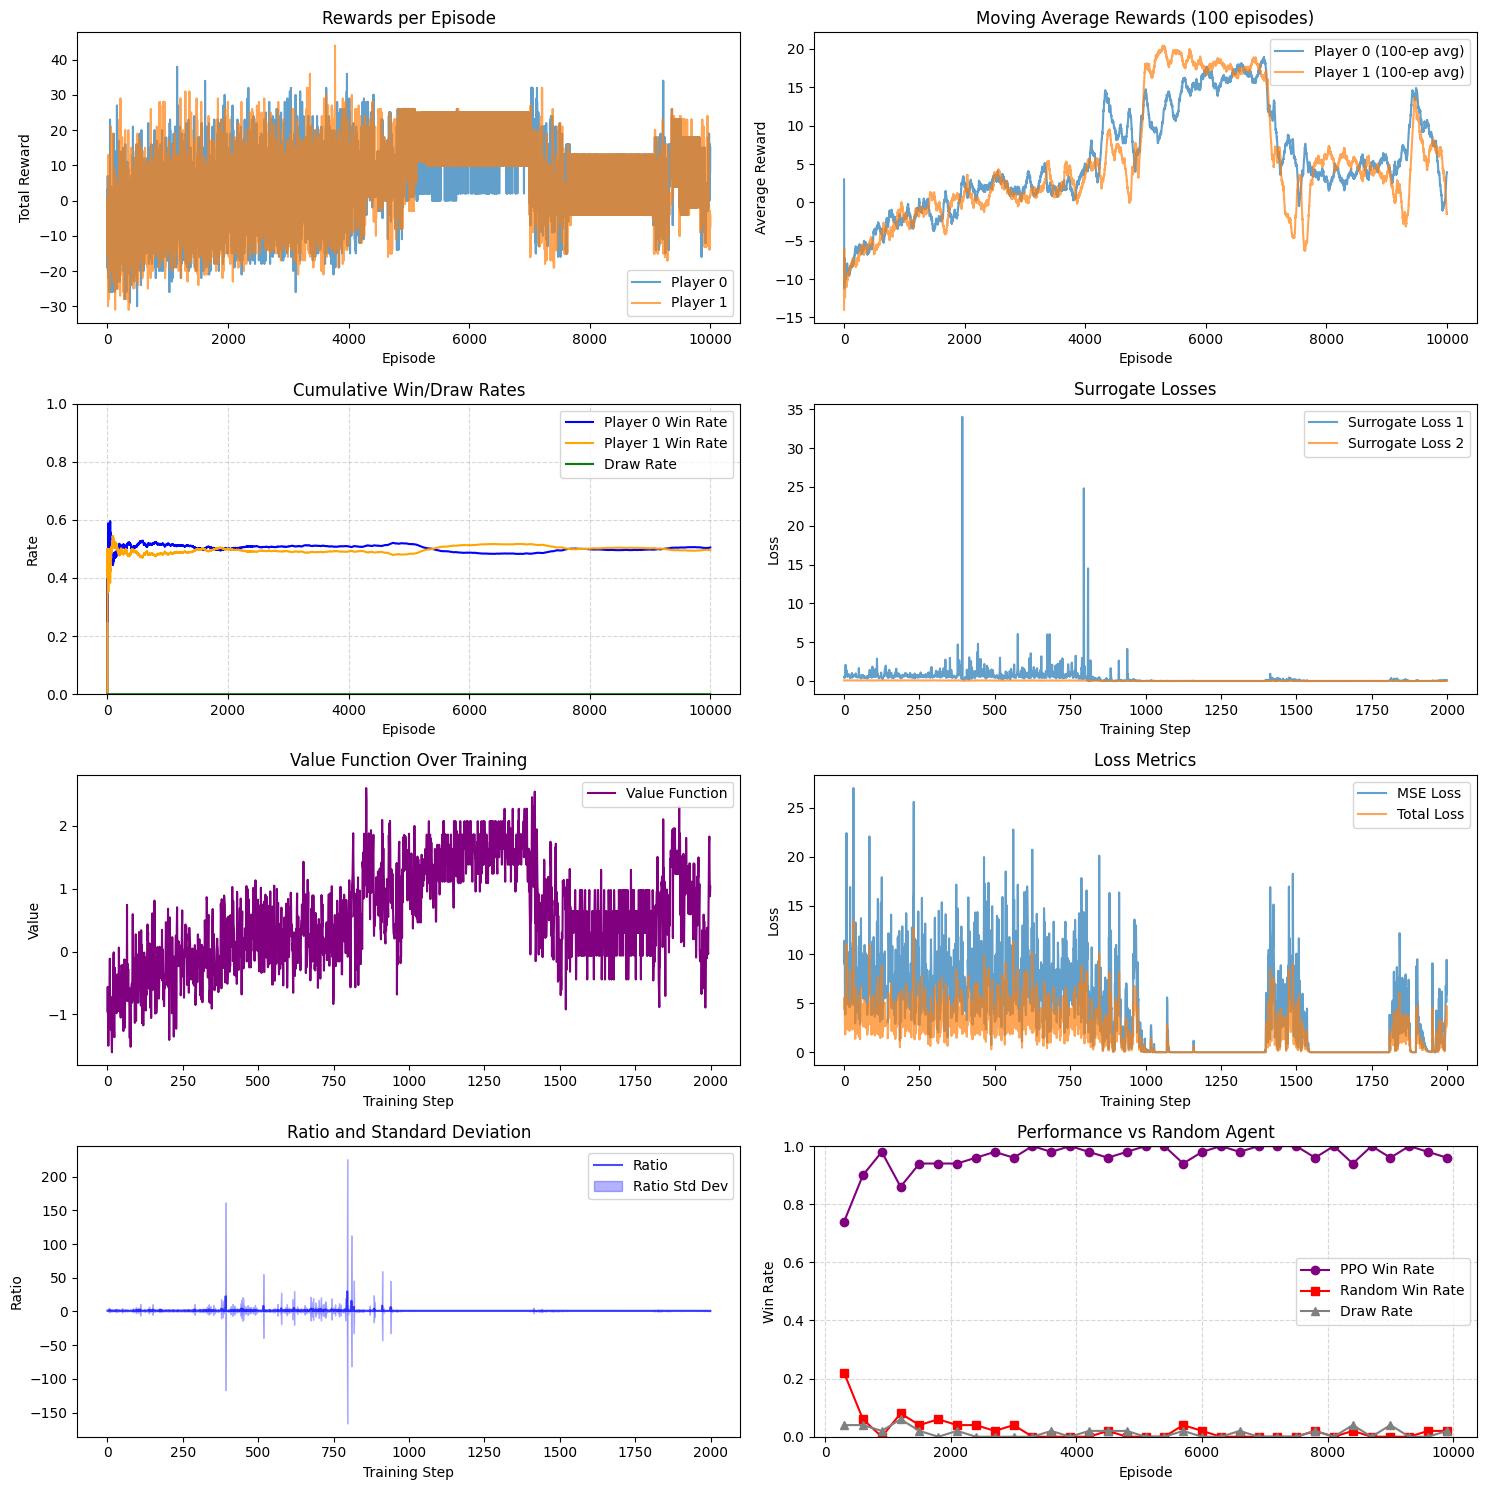

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Plot results
plt.figure(figsize=(15, 15))

# Plot rewards for both players
plt.subplot(4, 2, 1)
plt.plot(rewards_p0, label='Player 0', alpha=0.7)
plt.plot(rewards_p1, label='Player 1', alpha=0.7)
plt.title("Rewards per Episode")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.legend()

# Plot moving average of rewards for better visualization
window = 100
plt.subplot(4, 2, 2)
p0_avg = [np.mean(rewards_p0[max(0, i-window):i+1]) for i in range(len(rewards_p0))]
p1_avg = [np.mean(rewards_p1[max(0, i-window):i+1]) for i in range(len(rewards_p1))]
plt.plot(p0_avg, label='Player 0 (100-ep avg)', alpha=0.7)
plt.plot(p1_avg, label='Player 1 (100-ep avg)', alpha=0.7)
plt.title("Moving Average Rewards (100 episodes)")
plt.xlabel("Episode")
plt.ylabel("Average Reward")
plt.legend()

# Plot win rates for both players
plt.subplot(4, 2, 3)
total_games = np.arange(1, len(win_counts_p0) + 1)
p0_win_rates = np.array(win_counts_p0) / total_games
p1_win_rates = np.array(win_counts_p1) / total_games
draw_rates = np.array(draw_counts) / total_games

plt.plot(total_games, p0_win_rates, label='Player 0 Win Rate', color='blue')
plt.plot(total_games, p1_win_rates, label='Player 1 Win Rate', color='orange')
plt.plot(total_games, draw_rates, label='Draw Rate', color='green')
plt.title("Cumulative Win/Draw Rates")
plt.xlabel("Episode")
plt.ylabel("Rate")
plt.ylim(0, 1)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

# Plot surrogate losses
plt.subplot(4, 2, 4)
plt.plot(surr1_array, label='Surrogate Loss 1', alpha=0.7)
plt.plot(surr2_array, label='Surrogate Loss 2', alpha=0.7)
plt.title("Surrogate Losses")
plt.xlabel("Training Step")
plt.ylabel("Loss")
plt.legend()

# Plot value function loss
plt.subplot(4, 2, 5)
plt.plot(values_array, label='Value Function', color='purple')
plt.title("Value Function Over Training")
plt.xlabel("Training Step")
plt.ylabel("Value")
plt.legend()

# Plot loss components
plt.subplot(4, 2, 6)
plt.plot(mse_loss_array, label='MSE Loss', alpha=0.7)
plt.plot(total_loss_array, label='Total Loss', alpha=0.7)
plt.title("Loss Metrics")
plt.xlabel("Training Step")
plt.ylabel("Loss")
plt.legend()

plt.subplot(4, 2, 7)
plt.plot(ratio_array, label='Ratio', alpha=0.7, color='blue')
plt.fill_between(range(len(ratio_array)), 
                np.array(ratio_array) - np.array(ratio_std_array), 
                np.array(ratio_array) + np.array(ratio_std_array), 
                color='blue', alpha=0.3, label='Ratio Std Dev')
plt.title("Ratio and Standard Deviation")
plt.xlabel("Training Step")
plt.ylabel("Ratio")
plt.legend()

plt.subplot(4, 2, 8)
plt.plot(eval_episodes, ppo_win_rates, label='PPO Win Rate', color='purple', marker='o')
plt.plot(eval_episodes, random_win_rates, label='Random Win Rate', color='red', marker='s')
plt.plot(eval_episodes, eval_draw_rates, label='Draw Rate', color='gray', marker='^')
plt.title("Performance vs Random Agent")
plt.xlabel("Episode")
plt.ylabel("Win Rate")
plt.ylim(0, 1)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()

plt.tight_layout()
plt.savefig("ppo_self_play_training_results_extended.png")
plt.show()

### Evaluating against a random opponent

In [10]:
def evaluate_ppo_against_random(model_path, num_episodes=100, board_size=8, render=False):
    """
    Evaluate a trained PPO agent against a random policy after training is complete.
    
    Args:
        model_path (str): Path to the saved PPO model weights
        num_episodes (int): Number of evaluation episodes
        board_size (int): Size of the board
        render (bool): Whether to render the game
        
    Returns:
        dict: Evaluation metrics including win rate
    """
    env = cathedral_v0.env(
        board_size=board_size, 
        render_mode="ansi" if render else None, 
        per_move_rewards=True, 
        final_reward_score_difference=False
    )
    env.reset()
    
    # Get observation shape and action space
    player_0 = "player_0"  # PPO agent
    player_1 = "player_1"  # Random agent
    n_actions = env.action_space(player_0).n
    obs_shape = env.observe(player_0)["observation"].shape
    
    print(f"Loading model from {model_path}")
    
    # Initialize PPO agent
    ppo_agent = PPOCNN(
        obs_shape=obs_shape,
        action_dim=n_actions,
        lr_actor=lr_actor, 
        lr_critic=lr_critic,
        gamma=gamma,
        K_epochs=K_epochs,
        eps_clip=eps_clip
    )
    
    # Load model weights
    checkpoint = torch.load(model_path, weights_only=False)
    ppo_agent.policy.load_state_dict(checkpoint)
    ppo_agent.policy_old.load_state_dict(ppo_agent.policy.state_dict())
    
    # Set to evaluation mode
    ppo_agent.policy.eval()
    
    # Statistics
    stats = {
        'ppo_wins': 0,
        'random_wins': 0,
        'draws': 0,
        'ppo_rewards': [],
        'random_rewards': [],
    }
    
    for episode in range(num_episodes):
        env.reset()
        list_agents = env.agents
        episode_reward_ppo = 0
        episode_reward_random = 0
        
        # Print progress
        if episode % 10 == 0:
            print(f"Playing episode {episode}/{num_episodes}")
        
        # Clear buffer for evaluation (since we don't need to preserve it post-training)
        ppo_agent.buffer.clear()
        
        while env.agents:
            current_agent = env.agent_selection
            observation = env.observe(current_agent)
            
            if current_agent == player_0:  # PPO agent's turn
                state = observation["observation"]
                action_mask = observation["action_mask"]
                
                # Use PPO to select action (deterministic for evaluation)
                action = ppo_agent.select_action_evaluation(state, action_mask)
                
                if render:
                    print(f'PPO action {action}')
                
            else:  # Random agent's turn
                action_mask = observation["action_mask"]
                
                # Random valid action
                valid_actions = np.where(action_mask == 1)[0]
                action = np.random.choice(valid_actions)
                
                if render:
                    print(f'Random action {action}')
            
            # Take action
            env.step(action)
            
            # Track rewards
            if current_agent == player_0:
                episode_reward_ppo += env.rewards[current_agent]
            else:
                episode_reward_random += env.rewards[current_agent]
        
        # Record game outcome
        winner = env.winner
        if winner != -1 and list_agents[winner] == player_0:
            stats['ppo_wins'] += 1
            if render:
                print(f'Episode {episode} - PPO wins!')
        elif winner != -1 and list_agents[winner] == player_1:
            stats['random_wins'] += 1
            if render:
                print(f'Episode {episode} - Random wins!')
        else:  # Draw
            stats['draws'] += 1
            if render:
                print(f'Episode {episode} - Draw!')
        
        # Record episode rewards
        stats['ppo_rewards'].append(episode_reward_ppo)
        stats['random_rewards'].append(episode_reward_random)
    
    # Calculate win rates
    stats['ppo_win_rate'] = stats['ppo_wins'] / num_episodes
    stats['random_win_rate'] = stats['random_wins'] / num_episodes
    stats['draw_rate'] = stats['draws'] / num_episodes
    
    # Calculate average rewards
    stats['avg_ppo_reward'] = sum(stats['ppo_rewards']) / num_episodes
    stats['avg_random_reward'] = sum(stats['random_rewards']) / num_episodes
    
    # Print summary
    print("\n===== Evaluation Results =====")
    print(f"Episodes played: {num_episodes}")
    print(f"PPO Wins: {stats['ppo_wins']} ({stats['ppo_win_rate']:.2%})")
    print(f"Random Wins: {stats['random_wins']} ({stats['random_win_rate']:.2%})")
    print(f"Draws: {stats['draws']} ({stats['draw_rate']:.2%})")
    print(f"Average PPO Reward: {stats['avg_ppo_reward']:.2f}")
    print(f"Average Random Reward: {stats['avg_random_reward']:.2f}")
    
    env.close()
    return stats

Loading model from model_weights_adversarial_PPO/cathedral_ppo_self_play_adversarial_6000.pth
Loading PPO CNN with 5, height 8, width 8
Loading PPO CNN with 5, height 8, width 8
Playing episode 0/200
Playing episode 10/200
Playing episode 20/200
Playing episode 30/200
Playing episode 40/200
Playing episode 50/200
Playing episode 60/200
Playing episode 70/200
Playing episode 80/200
Playing episode 90/200
Playing episode 100/200
Playing episode 110/200
Playing episode 120/200
Playing episode 130/200
Playing episode 140/200
Playing episode 150/200
Playing episode 160/200
Playing episode 170/200
Playing episode 180/200
Playing episode 190/200

===== Evaluation Results =====
Episodes played: 200
PPO Wins: 198 (99.00%)
Random Wins: 1 (0.50%)
Draws: 1 (0.50%)
Average PPO Reward: 13.73
Average Random Reward: -11.55


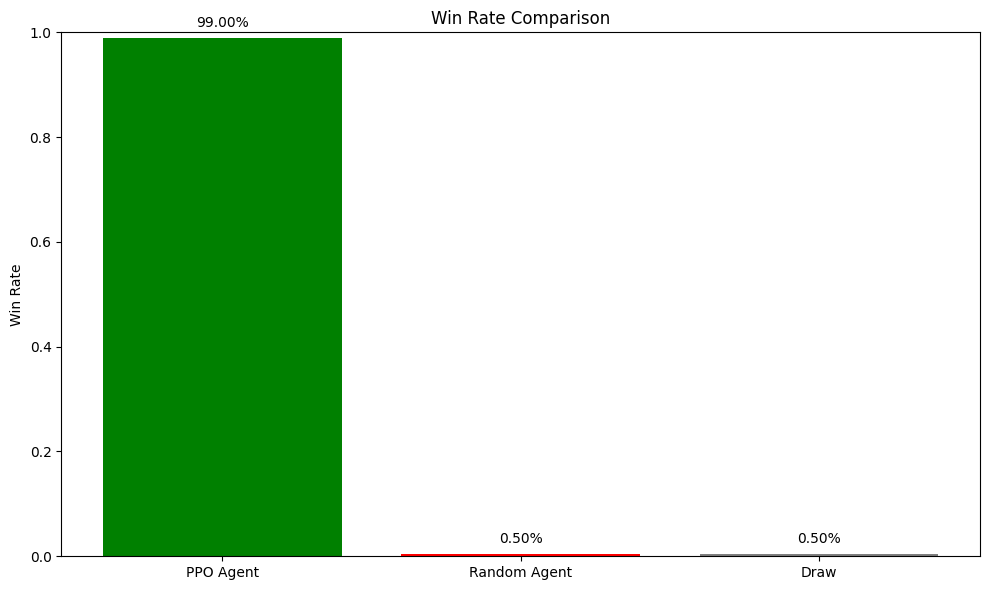

In [12]:
model_path = "model_weights_adversarial_PPO/cathedral_ppo_self_play_adversarial_6000.pth"

eval_stats = evaluate_ppo_against_random(
    model_path=model_path,
    num_episodes=200,
    board_size=8,
    render=False
)

# Create a bar chart of win rates
labels = ['PPO Agent', 'Random Agent', 'Draw']
values = [eval_stats['ppo_win_rate'], eval_stats['random_win_rate'], eval_stats['draw_rate']]
colors = ['green', 'red', 'gray']

plt.figure(figsize=(10, 6))
plt.bar(labels, values, color=colors)
plt.title('Win Rate Comparison')
plt.ylabel('Win Rate')
plt.ylim(0, 1)

for i, v in enumerate(values):
    plt.text(i, v + 0.02, f'{v:.2%}', ha='center')

plt.tight_layout()
plt.savefig('ppo_vs_random_evaluation.png')
plt.show()